## GaitSet Implements

In [1]:
import sys, os
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np

import torch.utils.data as data
import tarfile
import gzip
import cv2
import csv

from torch.utils.data import DataLoader

print(torch.__version__)
print(cv2.__version__)

0.4.1
4.0.0


### Settings

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Functions

In [3]:
def GAnMP(in_channels, num_stripes, out_channels):
    
    avg_pooling_list = nn.ModuleList([nn.AdaptiveAvgPool2d(1).to(device) for _ in range(num_stripes)])
    max_pooling_list = nn.ModuleList([nn.AdaptiveMaxPool2d(1).to(device) for _ in range(num_stripes)])
    fc_list = nn.ModuleList([nn.Linear(in_channels, out_channels, bias=False).to(device) for _ in range(num_stripes)])
    
    return avg_pooling_list, max_pooling_list, fc_list

In [4]:
def HPP(feats, num_stripes, avg_pool_list, max_pool_list, fc_list, feat_list = []):
    
    for i in range(num_stripes):
        
        res_avg = avg_pool_list[i](feats[:, :, i * (int)(feats.size(2) / num_stripes) : (i + 1) * (int)(feats.size(2) / num_stripes), :])
        res_max = max_pool_list[i](feats[:, :, i * (int)(feats.size(2) / num_stripes) : (i + 1) * (int)(feats.size(2) / num_stripes), :])
        
        res = res_avg + res_max
        res = res.view(feats.size(0), -1)        
        res = fc_list[i](res)
        
        feat_list.append(res)
        
    return feat_list

In [5]:
class ConvBlock(nn.Module):
    
    def __init__(self, channels_in, channels_out, kernel_size, **kwargs):
        super(ConvBlock, self).__init__()
        
        self.conv = nn.Conv2d(channels_in, channels_out, kernel_size, bias=False, **kwargs)
        
    def forward(self, input):
        input = self.conv(input)
        return F.leaky_relu(input, inplace=True)

In [6]:
class FrameBlock(nn.Module):
    
    def __init__(self, channels_in, channels_out, kernel_sizes, paddings, pooling=False):
        super(FrameBlock, self).__init__()
        
        self.pooling = pooling
        
        self.conv_1 = ConvBlock(channels_in, channels_out, kernel_sizes[0], padding=paddings[0])
        self.conv_2 = ConvBlock(channels_out, channels_out, kernel_sizes[1], padding=paddings[1])
        
        if pooling:
            self.pool = nn.MaxPool2d(2)
            
    def forward(self, input):
        n, s, c, h, w = input.size()
        input = self.conv_1(input.view(-1, c, h, w))
        input = self.conv_2(input)
        
        if self.pooling:
            input = self.pool(input)
        
        _, c, h, w = input.size()
        return input.view(n, s, c, h, w)        

### data

In [8]:
"""

Read Train, Test ID List

"""

with open('./data/OU_ISIR/ID_list.csv', 'r') as ID_list:
    lines = ID_list.readlines()
    
cooked = csv.reader(lines)
train_IDs = []
test_IDs = []
for record in cooked:
    if record[0] == 'Training subject ID' or record[0] == '':
        continue
    train_IDs.append(int(record[0]))
    test_IDs.append(int(record[1]))

In [9]:
def zero_pad(num, digit=3):
    n_str = str(num)
    while len(n_str) < digit:
        n_str = "0" + n_str
    return n_str

In [15]:
root_path = 'data/OU_ISIR/processed/'

img_list = []
seq_list = []
index_list = []
for view in os.listdir(root_path):    
    print(view)
    for pid in os.listdir( os.path.join( root_path, view)):    
        
        if int(pid) > 1000:
            break
        
        if int(pid) in train_IDs:
            for file in os.listdir(os.path.join(root_path, view, pid)):
                img = cv2.imread(os.path.join(root_path, view, pid, file))[:,:,0]
                
                if img is not None:
                    img_list.append(img)
                    
            seq_list.append(img_list)
            img_list = []
            index_list.append(pid)

Silhouette_000-00
Silhouette_000-01
Silhouette_015-00
Silhouette_015-01
Silhouette_030-00
Silhouette_030-01
Silhouette_045-00
Silhouette_045-01
Silhouette_060-00
Silhouette_060-01
Silhouette_075-00
Silhouette_075-01
Silhouette_090-00
Silhouette_090-01
Silhouette_180-00
Silhouette_180-01
Silhouette_195-00
Silhouette_195-01
Silhouette_210-00
Silhouette_210-01
Silhouette_225-00
Silhouette_225-01
Silhouette_240-00
Silhouette_240-01
Silhouette_255-00
Silhouette_255-01
Silhouette_270-00
Silhouette_270-01


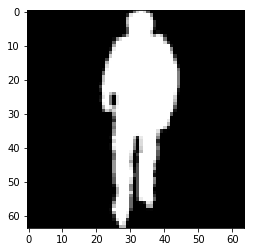

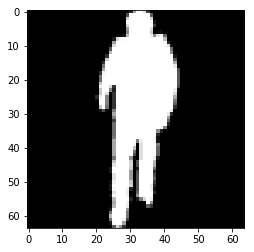

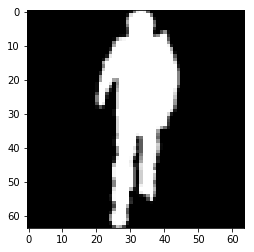

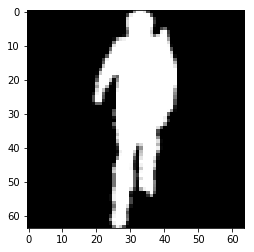

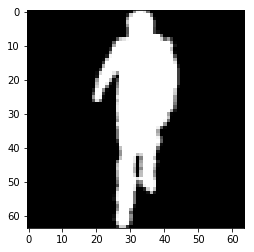

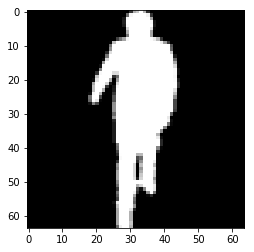

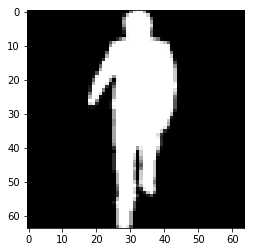

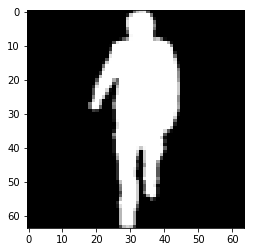

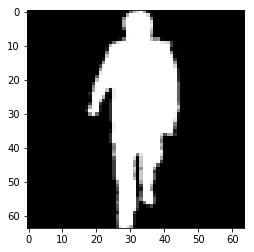

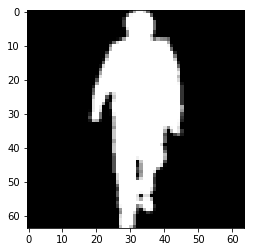

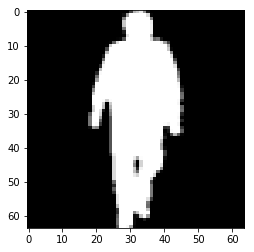

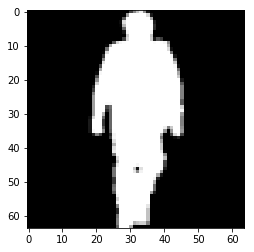

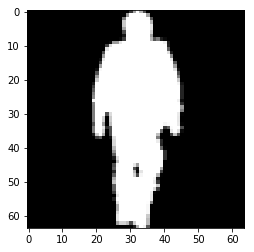

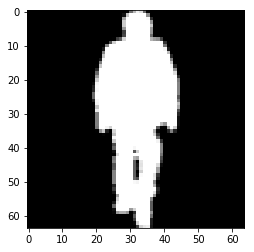

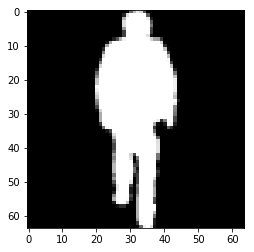

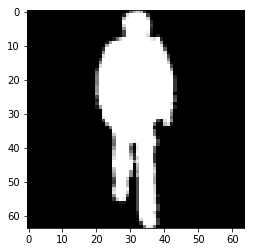

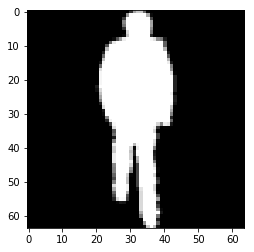

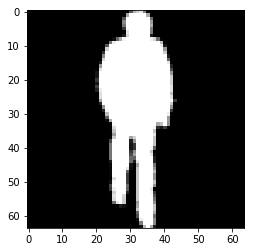

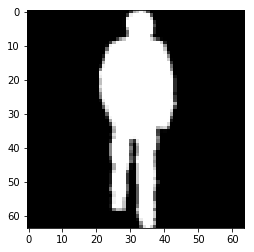

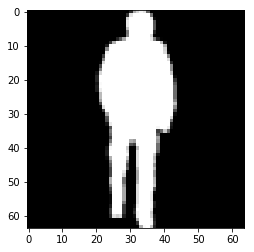

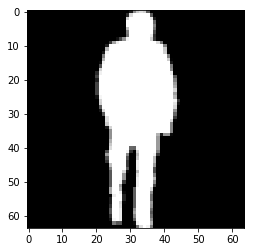

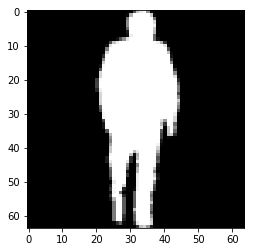

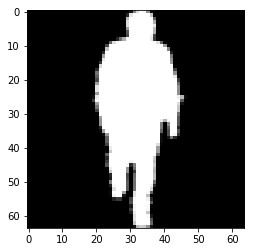

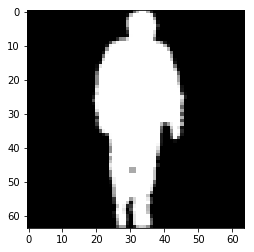

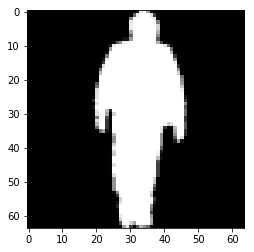

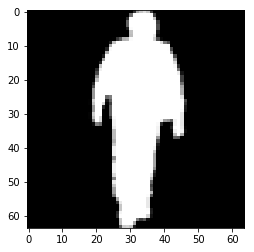

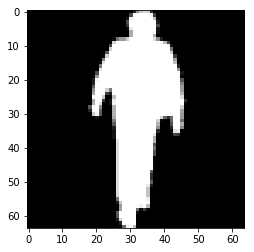

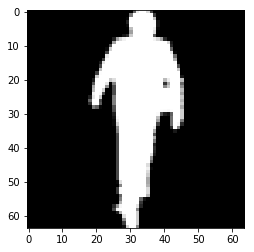

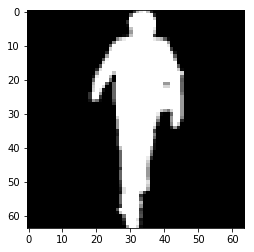

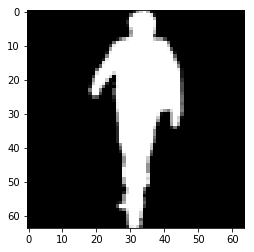

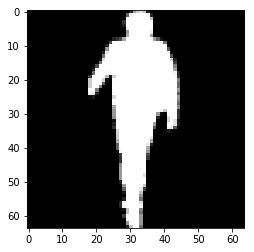

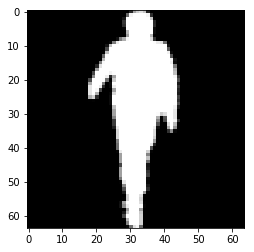

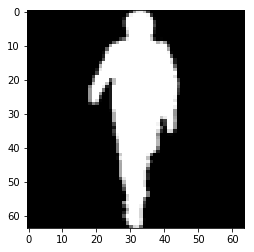

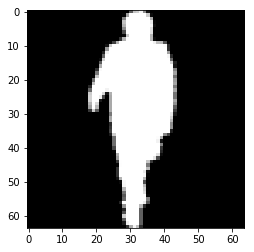

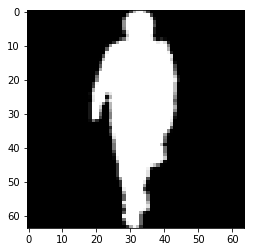

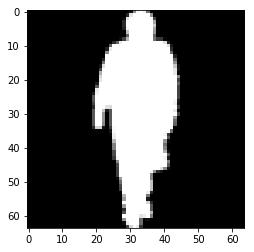

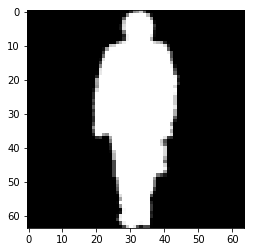

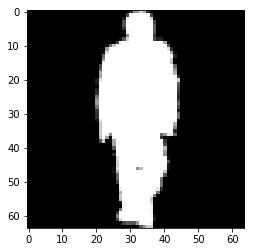

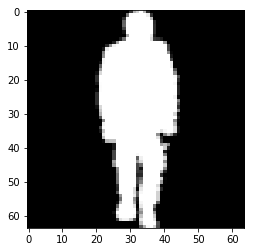

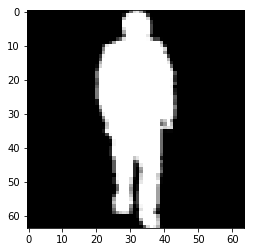

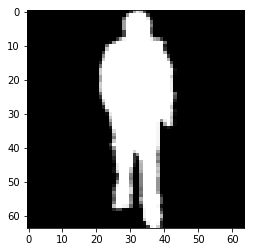

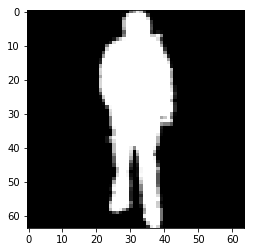

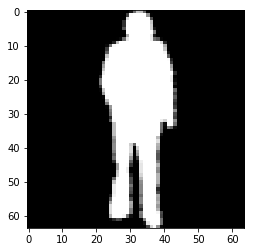

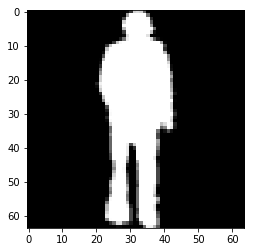

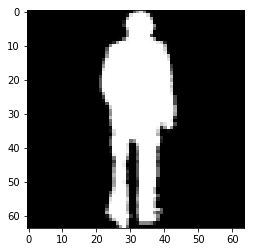

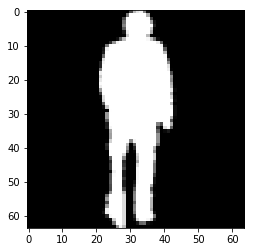

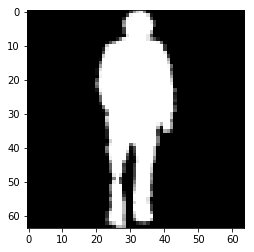

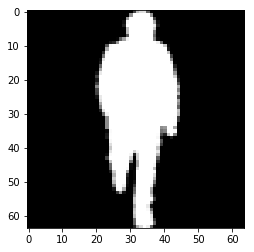

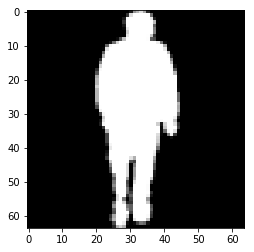

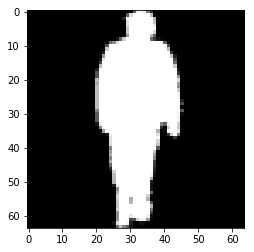

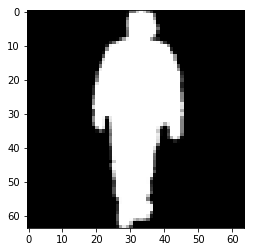

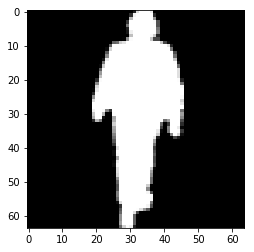

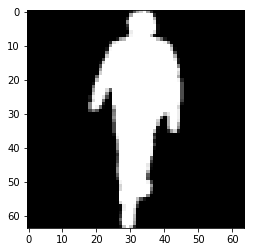

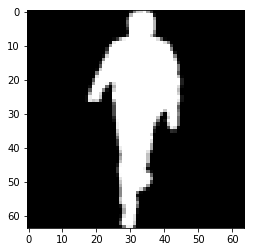

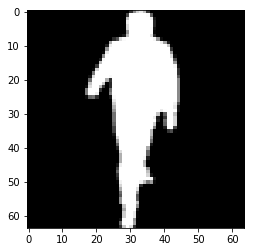

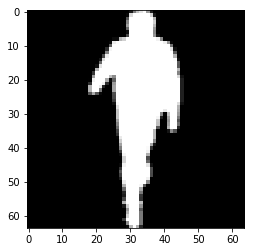

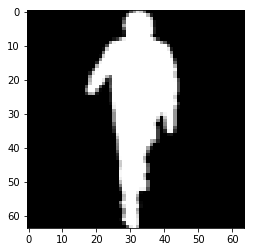

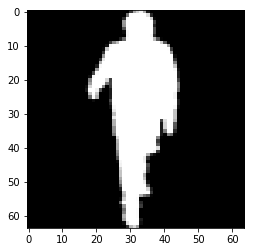

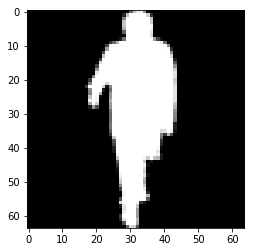

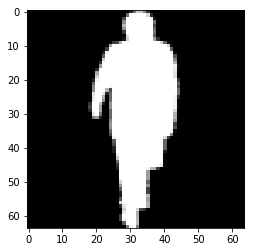

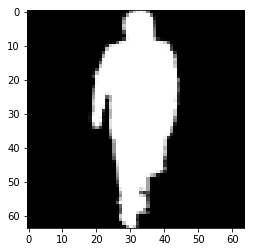

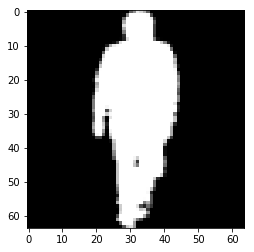

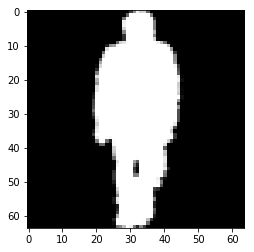

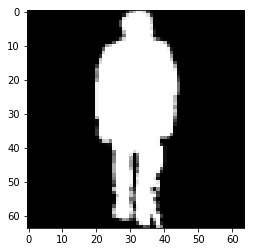

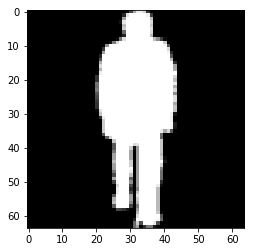

In [22]:
seq = seq_list[0]

for i in range(len(seq)):
    plt.imshow(seq[i], cmap='gray')
    plt.show()

In [9]:
root = 'data/OU_ISIR/processed/Silhouette_000-00/'
images_list = []

for idx in range(4000):
    file_path = os.path.join( root, zero_pad(train_IDs[idx], 5))
    
    if not os.path.exists(file_path):
        continue
        
    for file in os.listdir(file_path):
        img = cv2.imread(os.path.join(file_path, file))
        
        if not img is None:
            images_list.append(img.transpose(2, 0, 1)[0])
    
seq_images = torch.FloatTensor(images_list).to(device)
seq_images = seq_images.unsqueeze(0)
seq_images = seq_images.unsqueeze(2)
print(seq_images.size())

torch.Size([1, 210424, 1, 64, 64])


### network

In [ ]:
FB1 = FrameBlock(1, 32, [5, 3], [2, 1], True).to(device)
FB2 = FrameBlock(32, 64, [3, 3], [1, 1], True).to(device)
FB3 = FrameBlock(64, 128, [3, 3], [1, 1], False).to(device)

SB1 = nn.Sequential(
    ConvBlock(32, 64, 3, padding=1),
    ConvBlock(64, 64, 3, padding=1),
    nn.MaxPool2d(2)
).to(device)

SB2 = nn.Sequential(
    ConvBlock(64, 128, 3, padding=1),
    ConvBlock(128, 128, 3, padding=1)
).to(device)

ap1, mp1, fc1 = GAnMP(128, 1, 256)
ap2, mp2, fc2 = GAnMP(128, 2, 256)
ap3, mp3, fc3 = GAnMP(128, 4, 256)
ap4, mp4, fc4 = GAnMP(128, 8, 256)
ap5, mp5, fc5 = GAnMP(128, 16, 256)

### Triplet Loss

In [ ]:
class TripletLoss(nn.Module):
    
    def __init__(self, batch_size, margin, is_hard=True):
        super(TripletLoss, self).__init__()
        
        self.batch_size = batch_size
        self.margin = margin
        self.is_hard = is_hard
        
    def forward(self, feature, label):
        """
            [ input ]
            
                [ feature ] : [ n, m, d ]
                [ label ] : [ n, m ]
            
            - n : batch_size
            - m : 62 ( scale is 5, so 1 + 2 + 4 + 8 + 16 ) * 2 ( local and global )
            - d : hidden_dim
        """
        n, m, d = feature.size()
        
        """ 
            [ hard ]
            
                [ hp_mask ] : hard positive mask
                [ hn_mask ] : hard negative mask
        """
        hp_mask = ( label.unsqueeze(1) == label.unsqueeze(2) ).byte().view(-1)
        hn_mask = ( label.unsqueeze(1) != label.unsqueeze(2) ).byte().view(-1)
        
        dist = self.batch_dist(feature)
        dist_mean = dist.mean(1).mean(1)
        dist = dist.view(-1)
        
        hard_hp_dist = torch.max(torch.masked_select(dist, hp_mask).view(n, m, -1), 2)[0]
        hard_hn_dist = torch.min(torch.masked_select(dist, hn_mask).view(n, m, -1), 2)[0]
        hard_loss_metric = F.relu(self.margin + hard_hp_dist - hard_hn_dist).view(n, -1)
        
        hard_loss_metric_mean = torch.mean(hard_loss_metric, 1)
        
        """ [ Full ] """
        full_hp_dist = torch.masked_select(dist, hp_mask).view(n, m, -1, 1)
        full_hn_dist = torch.masked_select(dist, hn_mask).view(n, m, 1, -1)
        full_loss_metric = F.relu(self.margin + full_hp_dist - full_hn_dist).view(n, -1)
        
        full_loss_metric_sum = full_loss_metric.sum(1)
        full_loss_num = (full_loss_metric !=0).sum(1).float()
        
        full_loss_metric_mean = full_loss_metric_sum / full_loss_num
        full_loss_metric_mean[ full_loss_num == 0 ] = 0
        
        return full_loss_metric_mean, hard_loss_metric_mean, dist_mean, full_loss_num
        
    def batch_dist(self, input):
        tmp = torch.sum( input**2 , 2 )
        dist = tmp.unsqueeze(2) + tmp.unsqueeze(2).transpose(1, 2) - 2 * torch.matmul( input, input.transpose(1, 2))
        dist = torch.sqrt(F.relu(dist))
        
        return dist

In [ ]:
criterion = TripletLoss(1, 0.2, True)

### train

In [ ]:
num_bins = [1, 2, 4, 8, 16]
fc_bin = nn.ParameterList([
            nn.Parameter(
                nn.init.xavier_uniform_(
                    torch.zeros(sum(num_bins) * 2, 128, 100)))]).to(device)

output = FB1(seq_images)
gl_output = SB1(torch.max(output, 1)[0])

output = FB2(output)
gl_output = SB2(gl_output + torch.max(output, 1)[0])

output = FB3(output)
output = torch.max(output, 1)[0]

gl_output = gl_output + output

# Do HPP
feature = list()
n, c, h, w = gl_output.size()
for num_bin in num_bins:
    
    z = output.view(n, c, num_bin, -1)
    z = z.mean(3) + z.max(3)[0]
    feature.append(z)
    
    z = gl_output.view(n, c, num_bin, -1)
    z = z.mean(3) + z.max(3)[0]
    feature.append(z)

feature = torch.cat(feature, 2).permute(2, 0, 1).contiguous()
feature = feature.matmul(fc_bin[0])
feature = feature.permute(1, 0, 2).contiguous()

In [ ]:
output = FB1(seq_images)
gl_output = SB1(torch.max(output, 1)[0])

output = FB2(output)
gl_output = SB2(gl_output + torch.max(output, 1)[0])

output = FB3(output)
output = torch.max(output, 1)[0]

gl_output = gl_output + output

# Do HPP
feat_list = HPP(gl_output, 1, ap1, mp1, fc1, [])
feat_list = HPP(gl_output, 2, ap2, mp2, fc2, feat_list)
feat_list = HPP(gl_output, 4, ap3, mp3, fc3, feat_list)
feat_list = HPP(gl_output, 8, ap4, mp4, fc4, feat_list)
feat_list = HPP(gl_output, 16, ap5, mp5, fc5, feat_list)

feat_list = HPP(output, 1, ap1, mp1, fc1, feat_list)
feat_list = HPP(output, 2, ap2, mp2, fc2, feat_list)
feat_list = HPP(output, 4, ap3, mp3, fc3, feat_list)
feat_list = HPP(output, 8, ap4, mp4, fc4, feat_list)
feat_list = HPP(output, 16, ap5, mp5, fc5, feat_list)

feat = torch.FloatTensor(feat_list)

In [ ]:
def batch_dist(input):
    tmp = torch.sum( input**2 , 2 )
    dist = tmp.unsqueeze(2) + tmp.unsqueeze(2).transpose(1, 2) - 2 * torch.matmul( input, input.transpose(1, 2))
    dist = torch.sqrt(F.relu(dist))

    return dist